# Customer Segmentation Report

## Goal:

The purpose of this analysis is to leverage unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. 

We'd like to identify the parts of the general population that are more likely to become part of Arvato future customer base. And, conversely, what parts of general population are less likely to become, and what features determine that.


# 00. Packages & Data
## a. Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from unsupervised_utils import *

## b. Data

In [2]:
%%time 
joint_dataset = pd.read_csv("../arvato_data_processed/joint_dataset_imputed.csv", low_memory = False, index_col = 'Unnamed: 0' )
joint_dataset

CPU times: user 1min 57s, sys: 5.92 s, total: 2min 3s
Wall time: 2min 3s


,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,2.0,3.0,3.0,4.0,0.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,3.0,2.0,2.0,0.0,1.0,3.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
932104,0.0,4.0,3.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
932105,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
932106,0.0,4.0,4.0,3.0,2.0,0.0,0.0,0.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 01. Feature Scaling

All our our numerical and ordinal/categorical features are represented as numbers. The vast majority of features represent some notion of ordering (numerical/ordinal), while categorical features usually occur in a binary fashion 0/1.

So, I am going to later apply Principal Components Analysis (PCA) on this dataset. Although PCA is used for continuous variables, we might use PCA in this case as a simplified/naive case. As shown below:

CPU times: user 11.9 s, sys: 792 ms, total: 12.7 s
Wall time: 12.7 s


[]

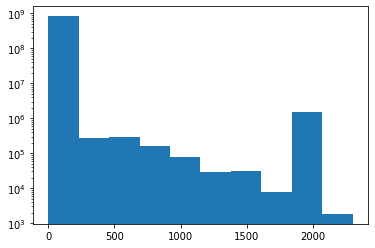

In [3]:
%%time
plt.hist(joint_dataset.to_numpy().reshape(-1),log=True)
plt.plot()

features are not standardizes. Some represent numerically the year, some represent a single ingerers (0,1,2,3,... etc). In order to treat each feature equally, regardless of the **scale** of the values it can take, I am going to apply a scikit-learn `StandardScaler`.

In [4]:
%%time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range=(-1, 1))
ss = StandardScaler()

column_names = joint_dataset.columns
joint_dataset = mm.fit_transform(joint_dataset)

joint_dataset = pd.DataFrame(joint_dataset,columns=column_names)
joint_dataset

CPU times: user 4.12 s, sys: 624 ms, total: 4.74 s
Wall time: 4.74 s


,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
0,0.0,-1.0,0.0,-0.333333,-1.0,-1.0,-1.0,-1.000000,0.0,0.2,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,-1.0,0.0,0.5,1.000000,1.0,-1.0,1.0,-1.000000,-0.5,-0.2,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,0.0,-1.0,0.0,-0.333333,-0.5,-1.0,-1.0,-1.000000,0.5,0.6,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,-1.0,-1.0,0.5,0.333333,0.0,-1.0,1.0,-0.142857,-0.5,-0.6,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
4,-1.0,1.0,0.0,0.333333,0.5,-1.0,-1.0,-1.000000,-0.5,0.2,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,-1.0,0.0,-0.5,-1.000000,0.0,-1.0,-1.0,-1.000000,-1.0,0.2,...,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
932104,-1.0,1.0,0.5,1.000000,0.0,-1.0,1.0,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
932105,-1.0,0.0,-0.5,-1.000000,0.5,-1.0,-1.0,-1.000000,-1.0,-0.2,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
932106,-1.0,1.0,1.0,1.000000,0.0,-1.0,-1.0,-1.000000,0.0,-0.6,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0


CPU times: user 15.2 s, sys: 696 ms, total: 15.9 s
Wall time: 15.9 s


[]

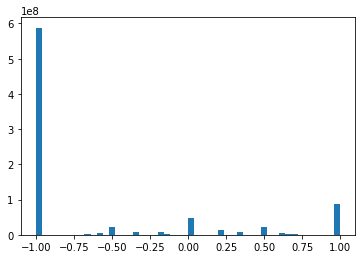

In [5]:
%%time
plt.hist(joint_dataset.to_numpy().reshape(-1),log=False,bins=50)
plt.plot()

In [8]:
np.unique(joint_dataset['D19_VERSI_ONLINE_QUOTE_12_6.0'])

array([-1.,  1.])

we see now that jointly the values taken in our dataset resemble a Gaussian with mean 0 and standard deviation of 1. 

# 02. Correlation analysis and feature grouping:



In [11]:
%%time

corr_threshold=0.90

corr =  joint_dataset.corr()
corr_abs = corr.abs()
joint_dataset,corr_abs,deleted_columns,feature_correlated = remove_correlated(joint_dataset,corr_threshold, corr_matrix=corr_abs)

print("Removed {} columns that were above {} correlation threshold".format(len(deleted_columns),corr_threshold))

Removed 16 columns that were above 0.9 correlation threshold
CPU times: user 17min 24s, sys: 11 s, total: 17min 35s
Wall time: 17min 35s


For future reference we keep the names of the deleted columns in `deleted_columns` variable, and the columns for which they were highly correlated in a dictionary `feature_correlated` shown below:

In [12]:
feature_correlated

{'KBA13_FAB_SONSTIGE': ['KBA13_HERST_SONST'],
 'KBA13_ALTERHALTER_61': ['KBA13_HALTER_66'],
 'D19_GESAMT_ONLINE_QUOTE_12': ['D19_VERSAND_ONLINE_QUOTE_12'],
 'KBA13_KMH_250': ['KBA13_KMH_211'],
 'ANZ_STATISTISCHE_HAUSHALTE': ['ANZ_HAUSHALTE_AKTIV'],
 'CAMEO_DEUINTL_2015': ['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015_SIM'],
 'D19_TELKO_ONLINE_QUOTE_12_0.0': ['D19_VERSI_ONLINE_QUOTE_12_0.0',
  'D19_KONSUMTYP_MAX_9'],
 'CJT_TYP_3_5.0': ['CJT_TYP_4_5.0'],
 'FIRMENDICHTE_5.0': ['GEBAEUDETYP_RASTER_5.0'],
 'LP_LEBENSPHASE_GROB_0.0': ['LP_LEBENSPHASE_FEIN_0.0'],
 'LP_FAMILIE_GROB_1.0': ['LP_FAMILIE_FEIN_1.0'],
 'LP_FAMILIE_GROB_2.0': ['LP_FAMILIE_FEIN_2.0'],
 'KBA05_MODTEMP_5.0': ['KBA05_HERSTTEMP_5.0'],
 'D19_KONSUMTYP_MAX_8': ['D19_KONSUMTYP_9.0']}

**For example** we see that `PLZ8_ANTG1` and `KBA13_ANTG1` are highly correlated features, from which `KBA13_ANTG1` was removed.

When looking back to **metadata descripton** `DIAS Attributes - Values 2017` we see that  `PLZ8_ANTG1` refers to "number of 1-2 family houses in the PLZ8", while for feature `KBA13_ANTG1` we lack any metadata description, and due to the common suffix they might refer to very similar feature.

Thus, we remove some 18 highly correlated features in this step of the analysis

Initial correlation matrix indicates that not many features are correlated with each other. I used `abs` to compute an absolute correlation coefficient. At this point we only care about the relative correlation, and not its directionality. 

In [14]:
corr.shape

(892, 892)

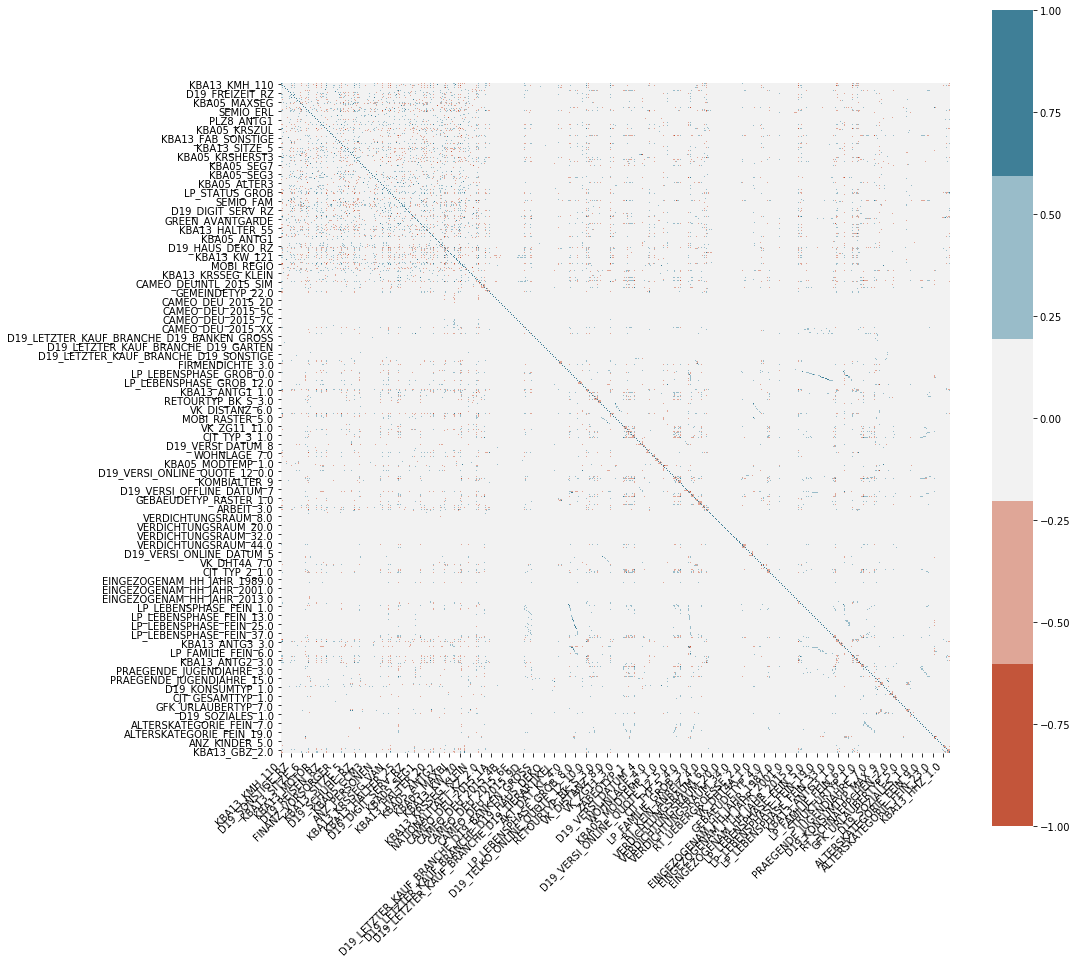

In [13]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 225, n=5),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# 02. Dimensionality reduction & Variance explained

As we want to cluster our data with many features, it would be beneficial to identifiy the redundancies in our dataset and redue the number of features to address the **curse of dimensionality** problem for clustering high dimensional data.

First. I will look over the variance explained by each features cumulatively, and compress the data so that it retains a significant portion of the variance explained. 

This 80% used below is an arbitrary threshold, a tradeoff between representing data accurately, and reducing the number of features. The compression is done by PCA: we identify ortogonal PC axes, that are a linear combination of features. As each PC is ordered by the importance (i.e. the amount of variance it explains), and we'll "trim" the last PC axes that contribute little to understand the dataset.



In [15]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components= joint_dataset.shape[1])
joint_dataset_PCA = pca.fit_transform(joint_dataset)

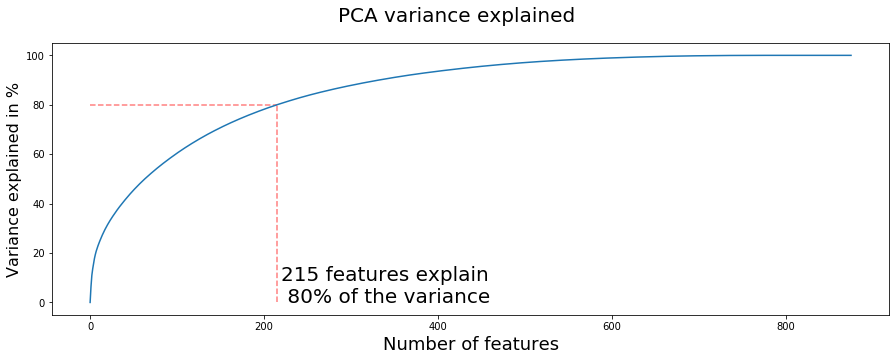

In [16]:
variance_explained(pca,80)

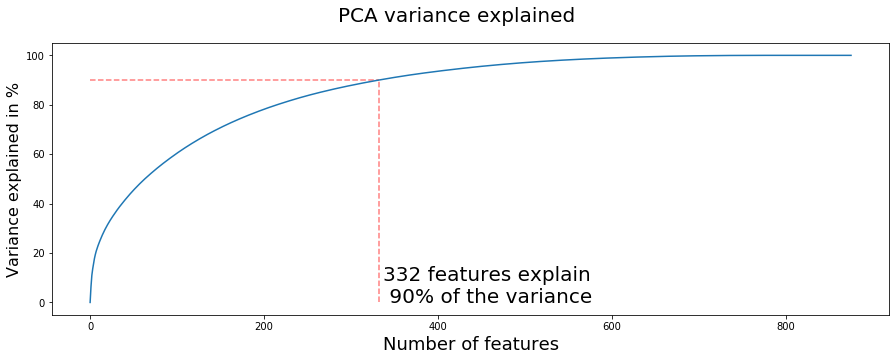

In [17]:
variance_explained(pca,90)

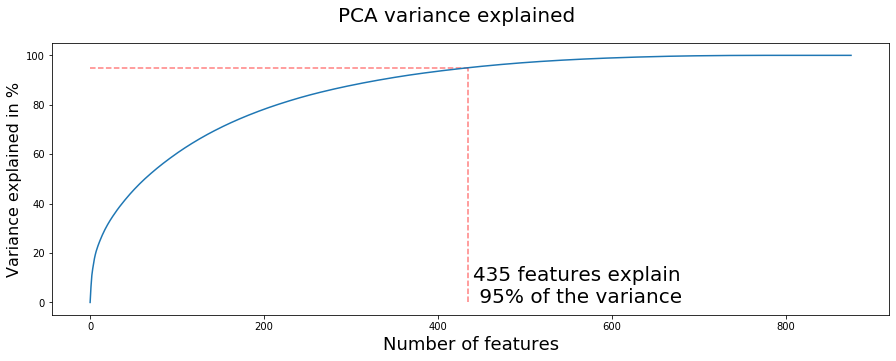

In [18]:
variance_explained(pca,95)

In [19]:
joint_dataset_PCA = pd.DataFrame(joint_dataset_PCA,columns=joint_dataset.columns)
joint_dataset_PCA

,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
0,-6.881385,2.768480,2.384437,-2.970263,-1.794474,1.646037,0.511248,-0.165435,-2.019601,-0.935936,...,1.247438e-14,3.001703e-15,-6.406983e-15,-7.992252e-15,9.751061e-15,4.134965e-15,2.799544e-15,-8.167509e-15,-5.853894e-15,1.184615e-15
1,-1.274147,6.852459,1.011670,-1.577932,-0.811514,-1.474080,2.349136,0.000167,-0.934805,3.451201,...,1.990805e-14,1.589967e-14,8.048368e-15,1.035657e-14,-9.938238e-15,-5.083238e-16,-7.963728e-15,4.228591e-15,-1.954413e-15,-2.188094e-16
2,-5.820283,1.659852,-2.576726,-1.217234,-2.759879,2.017917,0.801818,0.606609,0.813914,-2.315082,...,-3.285522e-15,-1.266563e-14,8.958048e-15,9.908043e-15,6.911876e-15,5.576119e-16,-3.135044e-15,-7.406296e-15,-3.528615e-15,2.569879e-15
3,2.070933,-0.488896,2.150218,4.488290,2.645374,1.847878,-0.990482,-4.351751,0.502767,2.901674,...,1.524138e-14,-5.544023e-15,1.930964e-14,1.423262e-15,1.510272e-15,-1.370723e-14,-8.236276e-15,1.210882e-15,4.921230e-15,-2.276402e-15
4,-4.537549,3.336891,6.387604,-1.766316,-0.681421,1.732701,-1.176126,-0.740861,1.463444,0.652291,...,6.997597e-16,1.905929e-14,-3.230390e-15,5.913247e-16,-7.236237e-15,-6.556913e-15,1.146378e-15,-3.535651e-15,4.702005e-16,-9.220660e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,0.477982,-5.166395,-0.340699,-0.852682,-0.739866,-2.519197,-0.205778,1.260891,0.530806,2.120618,...,-1.255701e-16,8.709563e-17,-6.329844e-17,2.876790e-17,-4.728286e-17,-2.935052e-17,-6.419291e-17,-2.589111e-17,-6.084313e-18,-1.673467e-17
932104,7.248155,0.915463,-0.635910,-0.103951,0.569204,1.346384,3.546160,-0.701866,0.372757,0.888691,...,2.652973e-17,2.100722e-17,6.343775e-17,-2.316759e-17,-6.193314e-17,3.397424e-17,2.928287e-17,-4.744225e-17,3.153772e-18,-9.363907e-18
932105,-0.893755,-5.905390,-0.561261,-1.600045,-1.505935,-1.951962,1.598843,-1.001025,1.075920,0.604594,...,6.068688e-17,-4.107804e-17,-4.552949e-17,-5.945161e-17,8.448244e-17,1.281870e-17,4.393730e-17,2.236177e-17,-2.640080e-17,1.445273e-17
932106,7.071785,-1.969070,-0.611305,1.400633,-4.354454,2.191783,-1.304681,-1.685727,-2.670279,0.286071,...,1.413076e-16,-6.279583e-18,-1.697170e-17,6.729779e-17,-5.640298e-18,-4.201127e-17,9.346893e-17,4.621635e-17,-3.334018e-17,6.584637e-18


In [20]:
joint_dataset_PCA_reduced = joint_dataset_PCA.iloc[:,:215]
joint_dataset_PCA_reduced.shape

(932108, 215)

# 03. Clustering

## A. Estimating the best number of clusters

- find optimal number of clusters
- show cluster distributions of azdias vs customers

- cluster centroids vs PCA

In [ ]:
%%time
sum_of_squared_distances,calinski_harabasz_scores = elbow_kmeans(X=joint_dataset_PCA_reduced, clusters=25)

import pickle

with open('sum_of_squared_distances.pkl', 'wb') as pickle_file:
    pickle.dump(sum_of_squared_distances, pickle_file)

with open('calinski_harabasz_scores.pkl', 'wb') as pickle_file:
    pickle.dump(calinski_harabasz_scores, pickle_file)



2/25
	 ...Fitted
	 Computed calinski harabasz score
	 Computed sum of squares distance score
3/25


In [ ]:
import pickle

with open('calinski_harabasz_scores.pkl', 'rb') as pickle_file:
    calinski_harabasz_scores = pickle.load(pickle_file)

with open('sum_of_squared_distances.pkl', 'rb') as pickle_file:
    sum_of_squared_distances = pickle.load(pickle_file)

It took around 3.5h hours to perform k-means clustering on our dataset with k varying from 2 to 25. Here are the scores:

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,10))

cluster_no = np.arange(2,25+1)

chosen_cluster=6

axs[0,0].plot(cluster_no, calinski_harabasz_scores)
axs[0,0].set_title("calinski_harabasz_scores")
axs[0,0].set_xlabel("# clusters")
axs[0,0].set_ylabel("calinski_harabasz_scores")
axs[0,0].vlines(chosen_cluster,ymax=max(calinski_harabasz_scores),ymin=min(calinski_harabasz_scores),color='red',linestyle='dashed',alpha=0.5)

axs[0,1].plot(cluster_no,sum_of_squared_distances)
axs[0,1].set_title("sum_of_squared_distances")
axs[0,1].set_xlabel("# clusters")
axs[0,1].set_ylabel("sum_of_squared_distances")
axs[0,1].vlines(chosen_cluster,ymax=max(sum_of_squared_distances),ymin=min(sum_of_squared_distances),color='red',linestyle='dashed',alpha=0.5)

axs[1,0].plot(cluster_no,np.gradient(calinski_harabasz_scores))
axs[1,0].set_title("SLOPE (gradient) calinski_harabasz_scores")
axs[1,0].set_xlabel("# clusters")
axs[1,0].set_ylabel("calinski_harabasz_scores")
axs[1,0].vlines(chosen_cluster,ymax=max(np.gradient(calinski_harabasz_scores)),ymin=min(np.gradient(calinski_harabasz_scores)),color='red',linestyle='dashed',alpha=0.5)


axs[1,1].plot(cluster_no,np.gradient(sum_of_squared_distances))
axs[1,1].set_title("SLOPE (gradient) sum_of_squared_distances")
axs[1,1].set_xlabel("# clusters")
axs[1,1].set_ylabel("sum_of_squared_distances")
axs[1,1].vlines(chosen_cluster,ymax=max(np.gradient(sum_of_squared_distances)),ymin=min(np.gradient(sum_of_squared_distances)),color='red',linestyle='dashed',alpha=0.5)


### Choosing the number of clusters (discussion)

Choosing the number of clusters is an arbitrary task. First, let's discuss metrics used:

1. `Calinski-Harabasz score`:  also known as the Variance Ratio Criterion. The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. Hence we want to obtain a minimum possible with the least amount of clusters available (the most conservative approach). If the number of clusters is equal to the number of points, then this score will be 0, but the solution would be far from optimal.

2. ` Inertia or the sum of square distances of samples` to their closest cluster center. The smaller the inertia, the better, but a naive minimization (as with calinski-harabasz score) is ill advised, as with number of clusters equal to the number of points we have a guarantee to obtain a minimum.


Hence, despite having two metrics, the choice of cluster number is arbitrary. And in a thorough experiments each would have to be tested. 


# I am going to assume that the number of clusters is 6
I decided on that number based on the shape of the elbow from both score. I also print the gradient (i.e. derivative) of the scores, to show when the gradients ae becoming "flat" indicating a decrease in the "speed" of metric score decrease.

The optimal solution lies in the range 5-9. With **6 clusters** seeming to offer a nice score minimization, with conservative approach of not inflating the number of clusters.

The last step in deciding on the number of clusters, is to check the cluster assignement stability. 

I implemented a function `cluster_stability` in `unsupervised.utils.py` based on [this github post on scikit-learn page](https://github.com/scikit-learn/scikit-learn/issues/1091). Bascially I **randomly sample my dataset**, each time with different initialization seed corresponding to different centroid initialization locaitons. I  keep  only `percent` of the original data to save the time, and repeat this procedure `n_iter` times. For each iteration I compute the `adjusted_rand_score`.

"from scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html):
> "The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation)."

Thus, a score as close to 1.0 is good

In [ ]:
%%time

from sklearn.cluster import KMeans
from sklearn import metrics
estimator = KMeans(n_clusters=6)

cluster_stability_score = cluster_stability(joint_dataset_PCA_reduced.to_numpy(),estimator,percent=.25 ,n_iter=10)
cluster_stability_score

We see that if we run 10 iterations, each time randomly bootstrap a dataset containing 25% of our dataset, and compute the clustering with **6 clusters**, we obtain a very high adjusted RAND Index, meaning **that 6 clusters assignement** is a very stable measure.

The rand index score is around **0.97**.

---
## B. Cluster relative abundances between Arvato `customers` and German general population: `azdias`.

We know from the notebook `03_Concatenate_and_Impute.ipynb` that:

> "The joint dataset has 932108 rows. The first 140864 rows are coming from customers dataset, the latter 791244 come from general population, i.e. AZDIAS dataset"

hence, we can recover dataset labels for the rows (observations). This is handy, as we can compare general population to ARVATO customer base

In [ ]:
%%time
estimator.fit(joint_dataset_PCA_reduced)
joint_dataset_PCA_reduced_labels = estimator.predict(joint_dataset_PCA_reduced)

In [ ]:
# num. of samples per dataset
azdias_samples = 791244 
customers_samples = 140864 

# create a Pandas Dataframe that would contain the relative percentage of class abundance PER DATASET
#    this would allow to compare class abundances between general population and arvato customers

DataSet_labels = ["customers"]*140864 + ["azdias"]*azdias_samples # dataset labels
assert len(DataSet_labels) == joint_dataset_PCA_reduced_labels.shape[0] #snity check
culuster_assignements = pd.DataFrame( {'Cluster': joint_dataset_PCA_reduced_labels,  'DataSet':DataSet_labels  }  )
culuster_assignements['count']=1
culuster_assignements = culuster_assignements.groupby(["DataSet","Cluster"]).count()

a = culuster_assignements.loc[('azdias')]*100/azdias_samples
a['dataset']='azdias'
a['cluster']=a.index


b = culuster_assignements.loc[('customers')]*100/customers_samples
b['dataset']='customers'
b['cluster']=b.index

culuster_assignements = pd.concat([a,b])
del a,b
culuster_assignements


In [ ]:
plt.figure(figsize=(25,3))
sns.catplot(x='cluster', y='count', hue='dataset', data=culuster_assignements, kind='bar')
 


## brief discussion: clusters relative abundance differences between `customers` and general populations `AZDIAS`

Before I go on to explore the characteristics of each cluster, I want to discuss the relative proportions on the above plot. We see that we have **6 clusters** on the x-axis. I plot the relative proportions for Arvato customers (`customers`) and the general population (`azdias`).  Each add separately naturaly to 100% relative abundance. 

We can observe the following:


**Clusters 0,2,5**:
    - these are the segments of general population for which Arvato has relatively less customers. Meaning this segment of population is **less likely to use the services**, as customers from this segment are less prevalent in our customer dataset.
    
**Clusters 1,3:**
    - these are the segments of general population that are overrepresented in Arvato customer base. Meaning, **this segment of population is much more likely (constitutes higher percentage) to use Arvato services**.
    
**Cluster 4:**
    - this is the segment of population that is  equally represented in customers dataset with relatively high percentage. Meaning this is also an important from the business perspective segment of the market.

---
# C. correlate PC with clusters

So, we ended up with **6 clusters** that are characterized by **6 centroids** each embedded in 169-dimensional space, as described by `joint_dataset_PCA_reduced`.



In [ ]:
centroids = pd.DataFrame(estimator.cluster_centers_, columns = ["PC_"+str(i) for i in range(1,170)])
centroids.index = ["Cluster_"+str(i) for i in range(0,6)]
centroids

In [ ]:
plt.figure(figsize = (20,15))
ax = sns.heatmap(centroids.T, cmap = 'RdBu',center=0)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")


plt.show()

(Figure Above) First, we see that although the reduced dataset (with 90% variance kept) is described by 169 PC axes, only the top 10 exibit values largely above/below zero. 

(Figure below) this we can zoom in on the first 10 PC axes:

In [ ]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(centroids.iloc[:,:5].T, cmap = 'RdBu',center=0)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

Looking at the heatmap above we can note **generalizations for each cluster**, such that:

**Note**, PCs are numbered from 1-169. Clusters are numbered from 0-5.

1. `Cluster_0`:
    - is described hugely by PC1 and PC2 and their anticorrelation
    
2. `Cluster_1`
    - is described primarly by positive values of PC1

3. `Cluster_2`
    - is described primarly by negative values of PC1

4. `Cluster_3`
    - is described primarly by positive values of PC3 and negative: PC1,PC2,PC4 (and to a lesser extent PC 5-10)

5. `Cluster_4`
    - is described primarly by positive values of PC5, and negative PC2, PC3

6. `Cluster_5`
    - is described primarly by comparatively medium (compared to other cluster) positive values of PC1,PC2, and negative values of P3, and to a lesser extent PC4-6


Now that I described how each cluster is relating to PC components, that are a linear combination of our original features. It is time to untangle the first 5 PC axes (for simplicity, but nothing prevents us from going to less impactful PCs 5-169).

---
## D. PC decomposition: feature importance

In order to better understand the makup of the clusters, we identified the PCs, and its values that largely define these clusters. 

But we can use the nature of the PCA as a linear combinaiton of our original feature space to entangle the "meaning" of each PC, by looking at top `n` contributors of variance to that PC.

I present the plots, and provide comments for first 5 PCs, each characterized by top 10 featues (variables defined in the raw dataset) regarding the potential interpretation of this axis.


One thing needs claryfing. The PCA components described below show the direction of maximum variance in the data. In particular if a particular feature has

- **POSITIVE** high component values, it means that as PC values increase, the values of a particular feature increase as well (positive correlation)

- **NEGATIVE** high component values, it means that as PC values increase, the values of a particular feature **decrease** (negative correlation).

This will be more evident in exampels shown below.

### Principal Component Axis #1 (PCA1)

In [ ]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA_reduced, 
                    pca_comonents = pca.components_, 
                    pca_num=1, 
                    n_weights=10,
                                      # Plotting/Figure parameters
                    alpha=0.025,
                    size=.5,
                    plot_arrows=True,
                    width=18,height=8)

### PCA 1 description:

**positive feature correlation** with PCA #1:
    - `CAMEO_DEU_2015`
    - `PLZ8_ANTG3`
    - `PLZ8_ANT4`

**negative feature correlation** with PCA #2:
    - 
    
     
In other words, interpreting the above:
- **HIGH VALUES of this PC axes**

- **LOW VALUES of this PC axes**
    
    

# 03. Variance explained